# Uczenie maszynowe w Python - Zaliczenie
## E-mail spam classifier

## Important 
<ul>
    <li>Dodać klasy: moje propozycje to:</li>
    <ul>
        <li>Data Analizer - dostaje dane posiada funckje analize() i zwrca wszelkie informacje o danych (shape, ham amout, spam amount, words per email, words in total)</li>
        <li>DataCleaner - dostaje columne texts i posiada funkcje clean(), zwraca text_clean</li>
        <li>ModelTester</li>
    </ul>
</ul>

In [65]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import RegexpTokenizer
from textblob import Word
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import time

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\piotr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piotr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Analysis of the dataset

In [59]:
class DataPreparator:
    
    def __init__(self, file_name):
        self.df = pd.read_csv(file_name)
        self.email_amount = 0
        self.ham_amount = 0
        self.spam_amount = 0
        self.word_count = 0
        self.avg_words = 0       
        
    # print out the information about the dataset
    def __str__(self):
        mark_line = "-" * 120
        data_info = f'The dataset contains {self.email_amount} emails, {self.ham_amount} ' \
                    f'of which are labeled as non-spam and {self.spam_amount} as spam. Between the emails, ' \
                    f'theres a total of {self.word_count} words,' \
                    f' with an average of ~{self.avg_words} words per email.'
        
        info = "\n".join([mark_line, data_info, mark_line])
        return info
            
    def analize(self):
        
        # label the unnamed column with ids
        self.df.rename(columns={'Unnamed: 0': 'id'}, inplace = True)
        print(80 * "*")
        print(self.df.head())
        print(80 * "*")

        # amount of emails in the dataset
        self.email_amount = self.df.shape[0]
        
        
        # Series with the amount of words in each email and their total count
        words_in_emails = (self.df['text'].apply(lambda x: len(str(x).split(" "))))
        self.word_count = np.sum(words_in_emails)
        
        # average amount of words in each email
        self.avg_words = round(np.divide(self.word_count, self.email_amount), 2)
        
        # amount of spam and ham emails 
        ham_and_spam_amount= self.df.groupby(['label']).count()
        self.ham_amount = ham_and_spam_amount.iloc[0, 0]
        self.spam_amount = ham_and_spam_amount.iloc[1, 0]



first_step = DataPreparator("spam_ham_dataset.csv")

first_step.analize()


print(first_step)


********************************************************************************
     id label                                               text  label_num
0   605   ham  Subject: enron methanol ; meter # : 988291\nth...          0
1  2349   ham  Subject: hpl nom for january 9 , 2001\n( see a...          0
2  3624   ham  Subject: neon retreat\nho ho ho , we ' re arou...          0
3  4685  spam  Subject: photoshop , windows , office . cheap ...          1
4  2030   ham  Subject: re : indian springs\nthis deal is to ...          0
********************************************************************************
------------------------------------------------------------------------------------------------------------------------
The dataset contains 5171 emails, 3672 of which are labeled as non-spam and 1499 as spam. Between the emails, theres a total of 1083244 words, with an average of ~209.48 words per email.
--------------------------------------------------------------------------

In [58]:
class DataCleaner:
    
    def __init__(self, analyzed_data):
        self.df = analyzed_data.df
        
    
    def applying_clean_contents(self):
        
        # apply the function to each row of the dataframe
        self.df['text_clean'] = self.df['text'].apply(lambda string: clean_contents(string))
        print(80 * "*")
        print(self.df.head())  # printing 5 rows after
        
   
    def cleaning_stopwords(self):
        stop = stopwords.words('english')
        self.df['text_clean'] = self.df['text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        print(80 * "*")
        print(self.df.head())
    
    # lemmatize the cleaned email contents
    def lemmatization(self):
        self.df['text_clean'] = self.df['text_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

        # show the first 10 rows after lemmatizing
        print(80 * "*")
        print(self.df['text_clean'].head(10))
        
    def clean_most_frequent_words(self):
        
        # define the most frequent words in the emails
        frequent_words = pd.Series(' '.join(self.df['text_clean']).split()).value_counts()
        frequent_words = frequent_words[frequent_words > 1000]
        
        # remove them from the email contents
        frequent_words = list(frequent_words.index)
        self.df['text_clean'] = self.df['text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in frequent_words))
        print(80 * "*")
        print(self.df['text_clean'].head())
        
# clean the contents of each email
def clean_contents(string, reg = RegexpTokenizer(r'[a-z]+')):
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

        
second_step = DataCleaner(result)

second_step.applying_clean_contents()
second_step.cleaning_stopwords()
second_step.lemmatization()
second_step.clean_most_frequent_words()


********************************************************************************
     id label                                               text  label_num  \
0   605   ham  Subject: enron methanol ; meter # : 988291\nth...          0   
1  2349   ham  Subject: hpl nom for january 9 , 2001\n( see a...          0   
2  3624   ham  Subject: neon retreat\nho ho ho , we ' re arou...          0   
3  4685  spam  Subject: photoshop , windows , office . cheap ...          1   
4  2030   ham  Subject: re : indian springs\nthis deal is to ...          0   

                                          text_clean  
0  subject enron methanol meter this is a follow ...  
1  subject hpl nom for january see attached file ...  
2  subject neon retreat ho ho ho we re around to ...  
3  subject photoshop windows office cheap main tr...  
4  subject re indian springs this deal is to book...  
********************************************************************************
     id label                    

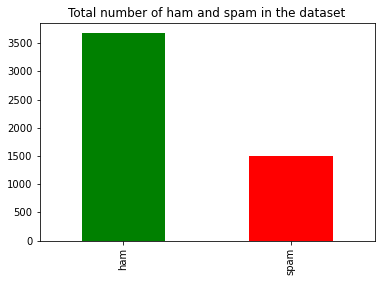

In [62]:
class Plots:
    
    def __init__(self, cleaned_data):
        self.df = cleaned_data.df
        
    def show_plot_second_step(self):
        self.df['label'].value_counts().plot.bar(color = ["g","r"])
        plt.title('Total number of ham and spam in the dataset')
        plt.show()
        
plot = Plots(second_step)
plot.show_plot_second_step()
        

In [ ]:
class Vectorizer:
    
    def __init__(self, cleaned_data):
        self.df = cleaned_data.df
        
    def vectorization:
        

In [67]:
# Convert a collection of text documents to a matrix of token counts
cv = CountVectorizer()
X = cv.fit_transform(second_step.df.text_clean)
 
# Get the categories
y = second_step.df.label
# Words exctracted from text_clean
print(cv.get_feature_names()[10:50:2])

['aaihmqv', 'aalland', 'aamlrg', 'aare', 'aaron', 'aavilable', 'ab', 'ababa', 'aback', 'abacus', 'abandon', 'abandoned', 'abasement', 'abashed', 'abater', 'abb', 'abbasi', 'abbey', 'abbott', 'abbreviation']
